In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [46]:
class Value:
    # 需要记录一些计算图
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None
    # 包装函数
    def __repr__(self):
        return f'Value(data={self.data})'
    # 每次运算过后 记录计算图中的节点
    # 加法
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0* output.grad
            other.grad += 1.0* output.grad
        output._backward = _backward
        return output
    # 乘法
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
        output._backward = _backward
        return output
    # 检查交换后是否可以进行相乘
    def __rmul__(self, other):
        return self * other
    # 取反
    def __neg__(self):
        return self * (-1)
    # 减法
    def __sub__(self, other):
        return self + (-other)
    # 幂数
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only support int/float'
        output = Value(self.data **other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * output.grad
        output._backward = _backward
        return output
    # 除法
    def __truediv__(self, other):
        return self * other**-1
    # 指数
    def exp(self):
        x = self.data
        output = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += output.data * output.grad
        output._backward = _backward
        return output 
    # tanh
    def tanh(self):
        x = self.data
        t = (math.exp(x)-math.exp(-x))/(math.exp(x)+math.exp(-x))
        output = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2)*output.grad
        output._backward = _backward
        return output
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    def __radd__(self, other):
        return self+other
    def __rsub__(self, other):
        return other + (-self)
    def __rtruediv__(self, other):
        return other * self**-1
    

In [3]:
# 绘制计算图
from graphviz import Digraph

def trace(root):
    # 点集合 边集合
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [5]:
a = Value(1.0, label='a')
a.exp()

Value(data=2.718281828459045)

In [22]:
# inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2+b; n.label='n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.backward()

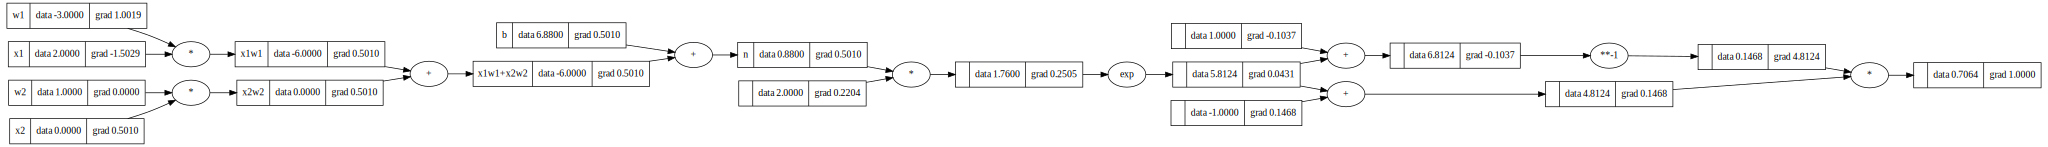

In [23]:
draw_dot(o)

In [54]:
# 构建MLP
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        output = act.tanh()
        return output
    def parameters(self):
        return self.w + [self.b]
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [60]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7074735154810751)

In [55]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9608255259434725),
 Value(data=0.46163672937070455),
 Value(data=0.4618477540525685),
 Value(data=0.9049222639469612)]

In [56]:
loss =  sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.283955199984606)

In [57]:
loss.backward()

In [58]:
n.layers[0].neurons[0].w[0].grad

6.327036977900077

In [62]:
lr = 0.01
for p in n.parameters():
    p.data -= lr * p.grad

In [63]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [76]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.376990925996168)

In [77]:
loss.backward()

In [78]:
for p in n.parameters():
    p.data -= lr * p.grad

In [94]:
y_preds = []

In [98]:
def train(epoches, learning_rate):
    for epoch in range(epoches):
        # forward
        ypred = [n(x) for x in xs]
        loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
        # zero_grad
        for p in n.parameters():
            p.grad = 0.0
        # backward
        loss.backward()
        # update
        for p in n.parameters():
            p.data -= lr*p.grad
        y_preds = ypred.copy()
        print(f'Epoch: {epoch}, Loss:{loss.data}')

In [99]:
train(150, 0.01)

Epoch: 0, Loss:0.002877150258895008
Epoch: 1, Loss:0.00287336557284889
Epoch: 2, Loss:0.0028695915198339345
Epoch: 3, Loss:0.002865828052400962
Epoch: 4, Loss:0.0028620751233945484
Epoch: 5, Loss:0.0028583326859503823
Epoch: 6, Loss:0.00285460069349334
Epoch: 7, Loss:0.0028508790997349353
Epoch: 8, Loss:0.002847167858671186
Epoch: 9, Loss:0.002843466924580386
Epoch: 10, Loss:0.0028397762520207632
Epoch: 11, Loss:0.0028360957958284503
Epoch: 12, Loss:0.002832425511115298
Epoch: 13, Loss:0.002828765353266543
Epoch: 14, Loss:0.002825115277938922
Epoch: 15, Loss:0.0028214752410583954
Epoch: 16, Loss:0.0028178451988180976
Epoch: 17, Loss:0.00281422510767632
Epoch: 18, Loss:0.002810614924354377
Epoch: 19, Loss:0.0028070146058346455
Epoch: 20, Loss:0.0028034241093585215
Epoch: 21, Loss:0.0027998433924243844
Epoch: 22, Loss:0.0027962724127857117
Epoch: 23, Loss:0.002792711128449049
Epoch: 24, Loss:0.002789159497672107
Epoch: 25, Loss:0.0027856174789618283
Epoch: 26, Loss:0.002782085031072494
E

In [100]:
y_preds

[]